In [12]:
from glob import glob

import theano

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from scipy.sparse import csc_matrix, csr_matrix


In [7]:
DL_PATH = '../examples/data/facial_feedback/*csv'

dfs = []
columns = ['subject', 'cond_id', 'condition', 'correct_c1', 'correct_c2', 'correct_c3', 'correct_c4',
           'correct_total', 'rating_t1', 'rating_t2', 'rating_c1', 'rating_c2', 'rating_c3',
           'rating_c4', 'self_perf', 'comprehension', 'awareness', 'transcript', 'age', 'gender',
           'student', 'occupation']

count = 0
for idx, study in enumerate(glob(DL_PATH)):
    data = pd.read_csv(study, encoding='latin1', skiprows=2, header=None, index_col=False).iloc[:, :22]
    data.columns = columns
    # Add study name
    data['study'] = idx
    # Some sites used the same subject id numbering schemes, so prepend with study to create unique ids.
    # Note that if we don't do this, Bambi would have no way of distinguishing two subjects who share
    # the same id, which would hose our results.
    data['uid'] = data['subject'].astype(float) + count
    dfs.append(data)

data = pd.concat(dfs, axis=0).apply(pd.to_numeric,  errors='coerce', axis=1)

In [8]:
valid = data.query('correct_total==4 and comprehension==1 and awareness==0')
long = pd.melt(valid, ['uid', 'condition', 'gender', 'age', 'study', 'self_perf'],
               ['rating_c1', 'rating_c2', 'rating_c3', 'rating_c4'], var_name='stimulus')

In [9]:
model = bmb.Model(
    "value ~ condition + age + gender + (1|uid) + (condition|study) + (condition|stimulus)",
    long,
    dropna=True,
)

group_specific_sd = bmb.Prior("HalfNormal", sigma=10)
group_specific_prior = bmb.Prior("Normal", mu=0, sigma=group_specific_sd)
model.set_priors(group_specific=group_specific_prior)

# Not we use 2000 samples for tuning and increase the taget_accept to 0.99.
# The default values result in divergences.
# results = model.fit(draws=1000, tune=2000, target_accept=0.99)

Automatically removing 33/6940 rows from the dataset.


In [10]:
model

Formula: value ~ condition + age + gender + (1|uid) + (condition|study) + (condition|stimulus)
Family name: Gaussian
Link: identity
Observations: 6907
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 4.5457, sigma: 28.4114)
    condition ~ Normal(mu: 0.0, sigma: 12.0966)
    age ~ Normal(mu: 0.0, sigma: 1.3011)
    gender ~ Normal(mu: 0.0, sigma: 13.1286)

  Group-level effects
    1|uid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 10))
    1|study ~ Normal(mu: 0, sigma: HalfNormal(sigma: 10))
    condition|study ~ Normal(mu: 0, sigma: HalfNormal(sigma: 10))
    1|stimulus ~ Normal(mu: 0, sigma: HalfNormal(sigma: 10))
    condition|stimulus ~ Normal(mu: 0, sigma: HalfNormal(sigma: 10))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 2.4186)

In [11]:
X = model._design.common.design_matrix
Z = model._design.group.design_matrix
print(X.shape)
print(Z.shape)

(6907, 4)
(6907, 231)


The same, but using PyMC code **AND** sparse matrices.

In [13]:
y = model._design.data.value.values

with pm.Model() as model_pm: 
    intercept = pm.Normal("intercept", sigma=3, shape=1)
    condition = pm.Normal("condition", sigma=0.5, shape=1)
    age = pm.Normal("age", sigma=0.3, shape=1)
    gender = pm.Normal("gender", sigma=0.5, shape=1)
    
    b = tt.concatenate([intercept, condition, age, gender])

    i1_sigma = pm.HalfNormal("1|uid_sigma")
    i1_offset = pm.Normal("1|uid_offset", shape=len(long.uid.unique()))
    i1 = pm.Deterministic("1|uid", i1_sigma * i1_offset)

    i2_sigma = pm.HalfNormal("1|study_sigma")
    i2_offset = pm.Normal("1|study_offset", shape=len(long.study.unique()))
    i2 = pm.Deterministic("1|study", i2_sigma * i2_offset)

    i3_sigma = pm.HalfNormal("condition|study_sigma")
    i3_offset = pm.Normal("condition|study_offset", shape=len(long.study.unique()))
    i3 = pm.Deterministic("condition|study", i3_sigma * i3_offset)

    i4_sigma = pm.HalfNormal("1|stimulus_sigma")
    i4_offset = pm.Normal("1|stimulus_offset", shape=len(long.stimulus.unique()))
    i4 = pm.Deterministic("1|stimulus", i4_sigma * i4_offset)

    i5_sigma = pm.HalfNormal("condition|stimulus_sigma")
    i5_offset = pm.Normal("condition|stimulus_offset", shape=len(long.stimulus.unique()))
    i5 = pm.Deterministic("condition|stimulus", i5_sigma * i5_offset)

    u = tt.concatenate([i1, i2, i3, i4, i5])[:, np.newaxis]

    mu = pm.math.dot(X, b) + theano.sparse.structured_dot(csr_matrix(Z), u).flatten()

    mu = pm.Deterministic("mu", mu)
    
    sigma = pm.HalfStudentT("sigma", nu=4, sigma=2.4)
    value = pm.Normal("value", mu=mu, sigma=sigma, observed=y) 

    idata_pm = pm.sample(return_inferencedata=True, target_accept=0.95)

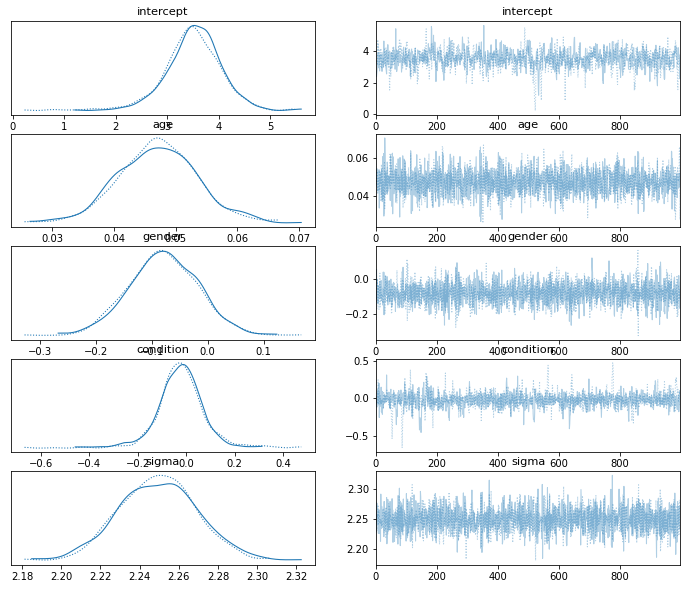

In [38]:
az.plot_trace(idata_pm, var_names=["intercept", "age", "gender", "condition", "sigma"]);

In [40]:
Z.shape

(6907, 231)

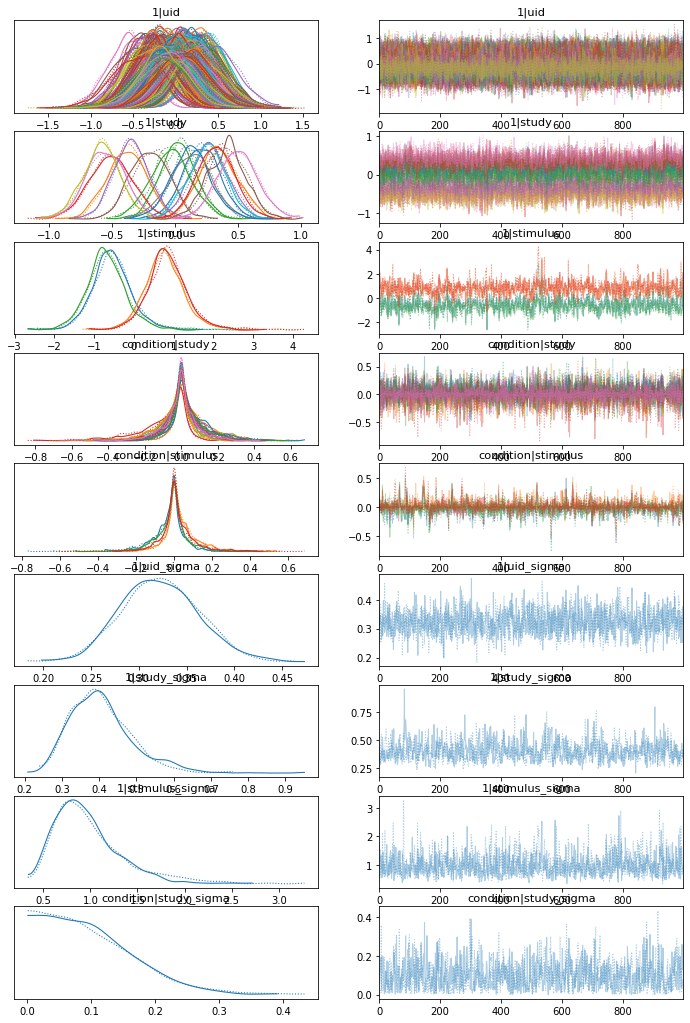

In [39]:
az.plot_trace(
    idata_pm, 
    var_names=[
        "1|uid",
        "1|study", 
        "1|stimulus", 
        "condition|study",
        "condition|stimulus",
        "1|uid_sigma",
        "1|study_sigma",
        "1|stimulus_sigma",
        "condition|study_sigma"
    ]
);